In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection
from tool import local_max, noise, circle, outliers, gaussian, make_histogram_projection, extract_data, get_k_equipartition, gaussian_analysis
import numpy.random as rand
from scipy.optimize import curve_fit
from scipy import integrate
import scipy.constants as cnst
from glob import glob

## Generate nm:px Conversion Ratio

[32.1598 32.2925 32.5363 ... 32.8029 32.8942 32.8164]

pixel sep = 236.8 +/- 0.98 [pixels]
nm/px = 42.23 +/- 0.175 [nm/px]
px/um = 23.68 +/- 0.098 [px/um]


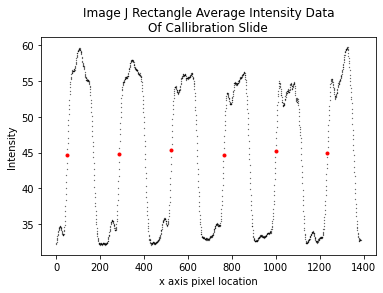

In [2]:
data = np.genfromtxt("/work/data/Calibration2.txt",delimiter='\t', skip_header = 1).T
x_dat = data[0]
y_dat = data[1]
print(y_dat)

maxes, idx = local_max(-np.abs(y_dat-45),N=90)

plt.plot(x_dat,y_dat,"k.",markersize=0.5)
plt.plot(x_dat[idx][::2],y_dat[idx][::2],"r.")
pixel_seperation = np.mean(np.diff(x_dat[idx][::2])) # separation in px
uncert_px = np.std(np.diff(x_dat[idx][::2]))
um_per_px = 10/pixel_seperation
um_per_px_err = (uncert_px/pixel_seperation)*um_per_px
plt.xlabel("x axis pixel location")
plt.ylabel("Intensity")
plt.title("Image J Rectangle Average Intensity Data\nOf Callibration Slide")

dec = 3
print("\npixel sep =",np.around(pixel_seperation,dec),"+/-",np.around(uncert_px,dec),"[pixels]")

print("nm/px =",np.around(um_per_px*1000,dec),"+/-",np.around(um_per_px_err*1000,dec),"[nm/px]")

print("px/um =",np.around(um_per_px**(-1),dec),"+/-",np.around((um_per_px_err/um_per_px)*um_per_px**(-1),dec),"[px/um]")


## Find Average Lab Temp

In [3]:
tempArray = np.array([22,20,20,21,19]) # C, via Meterman 33XR with thermocouple
tempArray = tempArray + 273.15

aveTemp = np.mean(tempArray)
tempErr = np.std(tempArray)/np.sqrt(len(tempArray))

print(f"Temperature = {aveTemp:.1f} +/- {tempErr:.1f} [K]")

T = aveTemp

Temperature = 293.6 +/- 0.5 [K]


## Import Sample D Raw Data

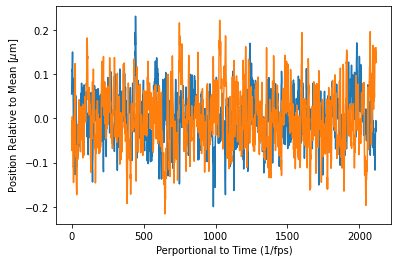

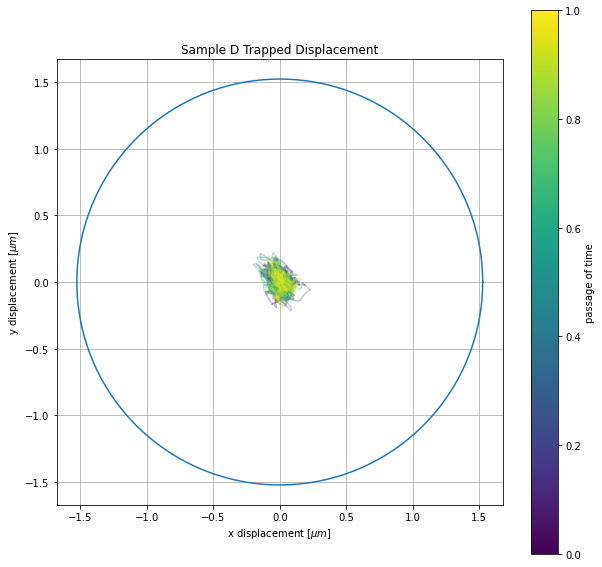

In [4]:
filename = "/work/data/SampleD_trapped2.txt"
data = extract_data(filename, skip_footer = 1200)
x = data.x
y = data.y
rad_dat = data.rad_dat

plt.plot(x,label=r"x position")
plt.plot(y,label=r"y position")
plt.xlabel("Perportional to Time (1/fps)")
plt.ylabel("Position Relative to Mean [$\mu$m]")
plt.show()

fig, ax = plt.subplots(figsize = (10,10))

#no idea how this formatting works
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

lc = LineCollection(segments, cmap='viridis', alpha = 0.3)
lc.set_array(np.linspace(0,1,len(x)))
line = ax.add_collection(lc)


thetas = np.linspace(0, 2*np.pi, 200)
circle_x, circle_y = circle(thetas, radius = np.mean(rad_dat))
fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax,label = "passage of time")
ax.grid()
ax.plot(circle_x, circle_y)
ax.set(ylabel = "y displacement [$\mu m$]", xlabel = "x displacement [$\mu m$]", title = "Sample D Trapped Displacement",
        aspect = 'equal')

        

x_trapped = x
y_trapped = y



with drift removed std x = 0.0388264215111741
with drift removed std y = 0.04754312345812869


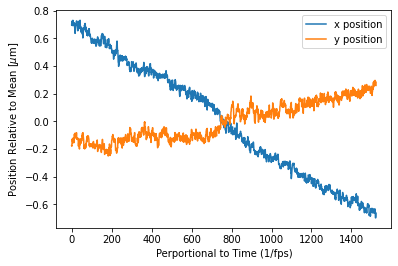

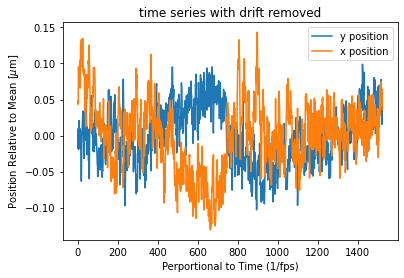

[Text(0, 0.5, 'y displacement [$\\mu m$]'),
 Text(0.5, 0, 'x displacement [$\\mu m$]'),
 Text(0.5, 1.0, 'Sample D Trapped Displacement'),
 None]

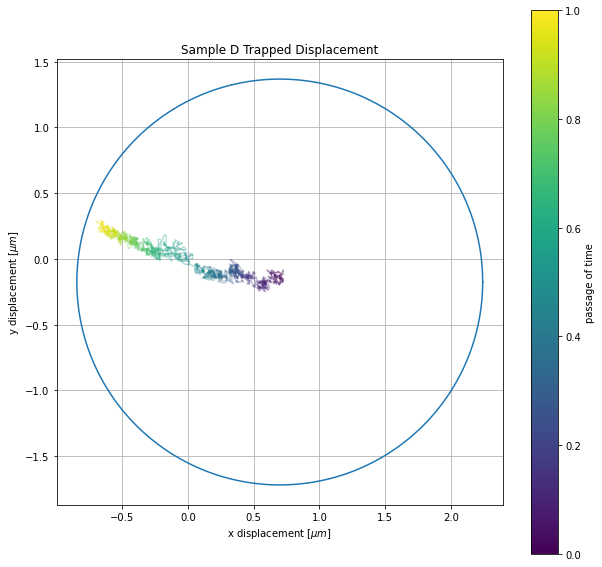

In [5]:
filename = "/work/data/SampleD_stuckBead4.txt"
data = extract_data(filename)
x = data.x_dat - np.mean(data.x_dat)
y = data.y_dat - np.mean(data.y_dat)
rad_dat = data.rad_dat

fitx = np.polynomial.Polynomial.fit(np.arange(0,len(x),1),x, deg = 1)
fity = np.polynomial.Polynomial.fit(np.arange(0,len(x),1),y, deg = 1)
x_no_drift = x - fitx(np.arange(0,len(x),1))
y_no_drift = y - fity(np.arange(0,len(x),1))

print(f"with drift removed std x = {np.std(x_no_drift)}")
print(f"with drift removed std y = {np.std(y_no_drift)}")

plt.plot(x,label=r"x position")
plt.plot(y,label=r"y position")

plt.xlabel("Perportional to Time (1/fps)")
plt.ylabel("Position Relative to Mean [$\mu$m]")
plt.legend()
plt.show()

plt.plot(x_no_drift, label = 'y position')
plt.plot(y_no_drift, label = 'x position')
plt.xlabel("Perportional to Time (1/fps)")
plt.ylabel("Position Relative to Mean [$\mu$m]")
plt.title('time series with drift removed')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize = (10,10))

#no idea how this formatting works
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

lc = LineCollection(segments, cmap='viridis', alpha = 0.3)
lc.set_array(np.linspace(0,1,len(x)))
line = ax.add_collection(lc)


thetas = np.linspace(0, 2*np.pi, 200)
circle_x, circle_y = circle(thetas, radius = np.mean(rad_dat))
circle_x += x[0]
circle_y += y[0]

fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax,label = "passage of time")
ax.grid()
ax.plot(circle_x, circle_y)
ax.set(ylabel = "y displacement [$\mu m$]", xlabel = "x displacement [$\mu m$]", title = "Sample D Trapped Displacement",
        aspect = 'equal')

142 outliers found


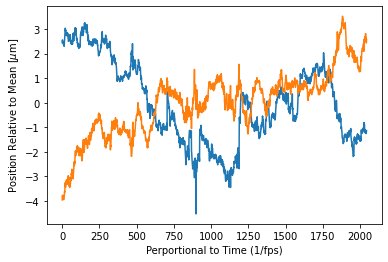

[Text(0, 0.5, 'y displacement [$\\mu m$]'),
 Text(0.5, 0, 'x displacement [$\\mu m$]'),
 Text(0.5, 1.0, 'Sample D Trapped Displacement'),
 None]

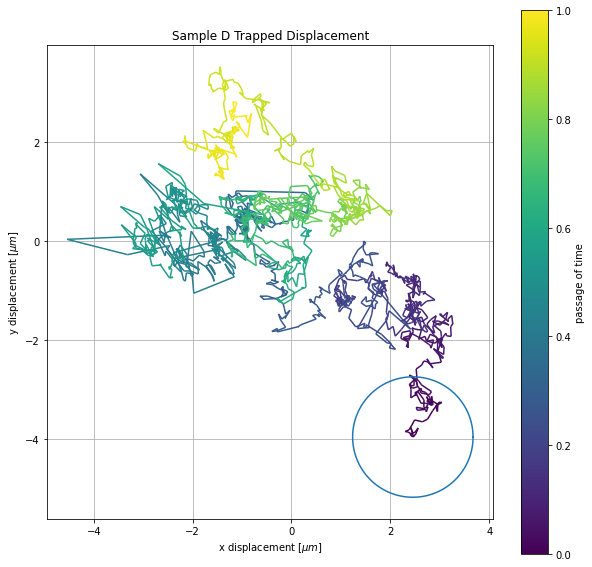

In [6]:
filename = "/work/data/SampleD_loneRandomWalk.txt"
data = extract_data(filename)
x = data.x_dat - np.mean(data.x_dat)
y = data.y_dat - np.mean(data.y_dat)
rad_dat = data.rad_dat

plt.plot(x,label=r"x position")
plt.plot(y,label=r"y position")
plt.xlabel("Perportional to Time (1/fps)")
plt.ylabel("Position Relative to Mean [$\mu$m]")
plt.show()

fig, ax = plt.subplots(figsize = (10,10))

#no idea how this formatting works
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

lc = LineCollection(segments, cmap='viridis')
lc.set_array(np.linspace(0,1,len(x)))
line = ax.add_collection(lc)


thetas = np.linspace(0, 2*np.pi, 200)
circle_x, circle_y = circle(thetas, radius = np.mean(rad_dat))
circle_x += x[0]
circle_y += y[0]
fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax,label = "passage of time")
ax.grid()
ax.plot(circle_x, circle_y)
ax.set(ylabel = "y displacement [$\mu m$]", xlabel = "x displacement [$\mu m$]", title = "Sample D Trapped Displacement",
        aspect = 'equal')

### Autocorrelation Analysis

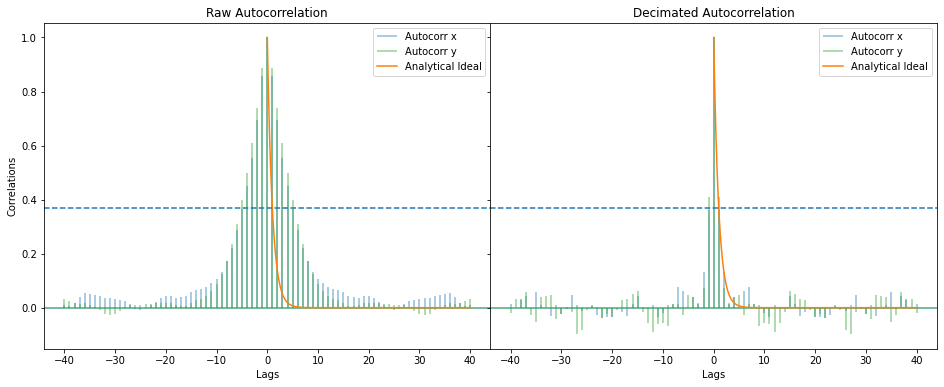

test


In [7]:
fig = plt.figure(figsize = (16,6))
gs = fig.add_gridspec(1,2, hspace=0,wspace = 0)
ax1, ax2 = gs.subplots(sharex=True, sharey=True)
#fig.suptitle('Autocorrelation for Decimation')

# Plot experimental autocorrelation
# I dont know if these are the values we want tho
k = 1
gamma = 1
tau_0 = k/gamma
deltaT = 0.01
D = 1 #= kB T / gamma

x = x_trapped
y = y_trapped

maxLagVal = 40
model = np.linspace(1e-5,maxLagVal,10000)

ax1.acorr(x, maxlags = maxLagVal,label = "Autocorr x",color = "C0",alpha = 0.5)
ax1.acorr(y, maxlags = maxLagVal,label = "Autocorr y",color = "C2",alpha = 0.5)
ax1.plot(model,D*tau_0*np.exp(-np.abs(model)/tau_0),label = "Analytical Ideal",color = "C1")
ax1.axhline(1/np.e,linestyle = "dashed")
ax1.set(title = "Raw Autocorrelation", xlabel = 'Lags', ylabel = "Correlations")
ax1.legend()


# Decimate data
interval = 5
x_dec = x[::interval]
y_dec = y[::interval]
#lol waht happened?
# idk did it shut down?

# Plot decimated autocorrelation
ax2.acorr(x_dec, maxlags = maxLagVal,label = "Autocorr x",color = "C0",alpha = 0.5)
ax2.acorr(y_dec, maxlags = maxLagVal,label = "Autocorr y",color = "C2",alpha = 0.5)
ax2.plot(model,D*tau_0*np.exp(-np.abs(model)/tau_0),label = "Analytical Ideal",color = "C1")
ax2.axhline(1/np.e,linestyle = "dashed")
ax2.legend()
ax2.set(title = "Decimated Autocorrelation",xlabel = "Lags")

plt.show()
print("test")

In [8]:
mean_x = np.mean(x)
mean_y = np.mean(y)

r = np.sum((x-mean_x)*(y-mean_y))/(np.sqrt(np.sum((x - mean_x)**2))*np.sqrt(np.sum((y - mean_y)**2)))

print(f"r = {r}")

r = -0.3385514290403072


### Equipartition Method - Determining k

In [9]:
# Eq 2) U = kx^2/2
# Eq 28) 1/2 k var(disp_from_mean) = 1/d k_b T
# therefore: k = k_b T / var(disp_from_mean)

k_b = cnst.Boltzmann # m^2 kg s-2 K-1
var_x = np.var(x_dec/(10**6))
var_y = np.var(y_dec/(10**6))

k_x = k_b*T/(var_x)
k_y = k_b*T/(var_y)

print("Spring Constant in x =",k_x,"[N/m]")
print("Spring Constant in y =",k_y,"[N/m]")

Spring Constant in x = 1.4683053451859432e-06 [N/m]
Spring Constant in y = 8.364447027021885e-07 [N/m]


# Gaussian fit method

Via Gaussian Fit Method
k_x = 0.47718455472126237
k_y = 0.5273068843074469
Via equipartition
k_x = 0.4663517870740569
k_y = 0.47906744942805907


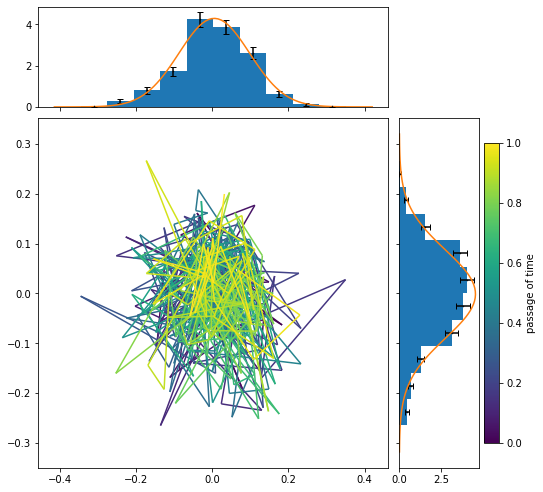

In [10]:
filename = "/work/data/SampleD_trapped1.txt"
ret = extract_data(filename)

analysis2 = make_histogram_projection(ret.x_dec, ret.y_dec, printBool = False)
print(f"Via Gaussian Fit Method\nk_x = {analysis2.k_x}\nk_y = {analysis2.k_y}")

k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
print(f"Via equipartition\nk_x = {k_x}\nk_y = {k_y}")

Via Gaussian Fit Method
k_x = 0.5953940758992894
k_y = 0.1972143838144209


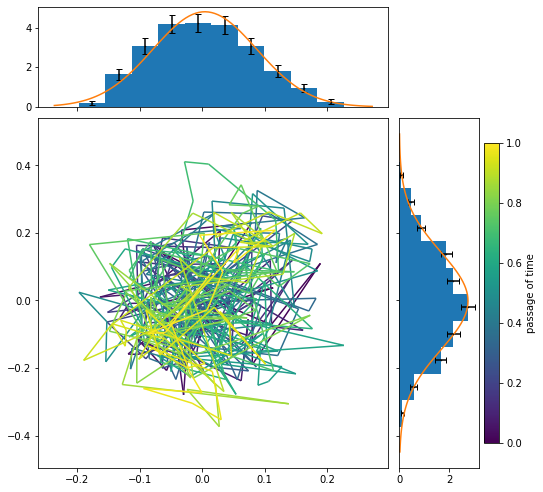

Via equipartition
k_x = 0.6212310144325284
k_y = 0.207863864843128


In [11]:
filename = '/work/data/reproducibility/SampleD_reproducibility1_data.txt'
ret = extract_data(filename)



analysis2 = make_histogram_projection(ret.x_dec, ret.y_dec, printBool = False)
print(f"Via Gaussian Fit Method\nk_x = {analysis2.k_x}\nk_y = {analysis2.k_y}")
plt.show()





k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
print(f"Via equipartition\nk_x = {k_x}\nk_y = {k_y}")

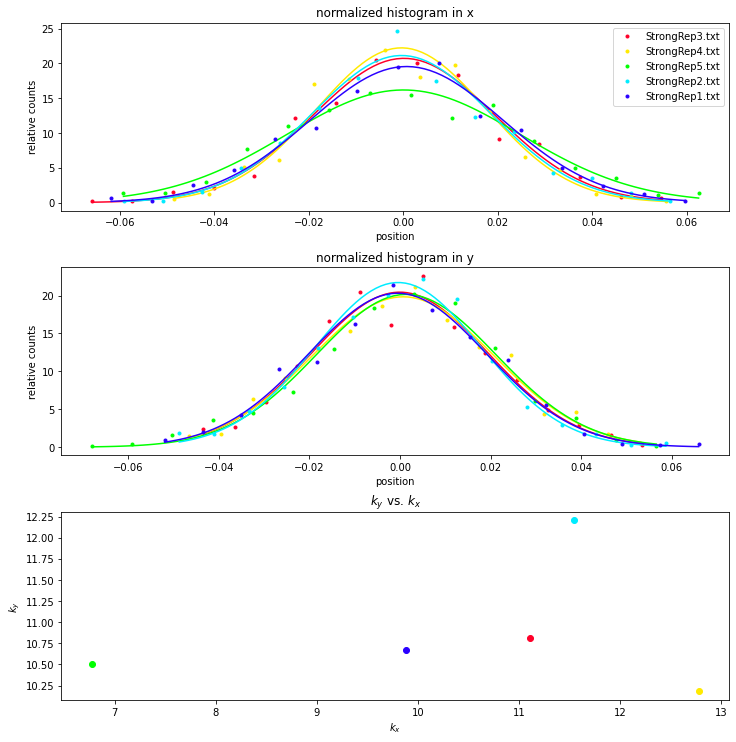

In [12]:

filenames = np.array(glob(('data/reproducibility/Strong*')))


fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (10,10))
fig.tight_layout()
colors = cm.get_cmap('gist_rainbow')
print(colors)
for i,filename in enumerate(filenames):
    color = colors(i/len(filenames))
    
    data = extract_data(filename)
    analysis = gaussian_analysis(data.x_dec, data.y_dec, nbins=15)
    dx = np.linspace(min(analysis.bins_x), max(analysis.bins_x), 100)
    ax1.plot(analysis.bins_x, analysis.hist_x, '.', color= color, label = filename.split('/')[-1])
    ax1.plot(dx, gaussian(dx,*analysis.pOpt_x), color= color)
    

    dx = np.linspace(min(analysis.bins_y), max(analysis.bins_y), 100)
    ax2.plot(analysis.bins_y, analysis.hist_y, '.',color= color,label = filename.split('/')[-1])
    ax2.plot(dx, gaussian(dx,*analysis.pOpt_y),color= color)
    ax3.scatter(analysis.k_x, analysis.k_y,color= color)
    

ax1.set(title = 'normalized histogram in x', xlabel = 'position', ylabel = 'relative counts')
ax2.set(title = 'normalized histogram in y', xlabel = 'position', ylabel = 'relative counts')
ax3.set(title = '$k_y$ vs. $k_x$', xlabel = '$k_x$', ylabel = '$k_y$')
plt.subplots_adjust(hspace = 0.3)
ax1.legend();
fig.savefig('Notes/reproducibility.pdf', bbox_inches = 'tight')




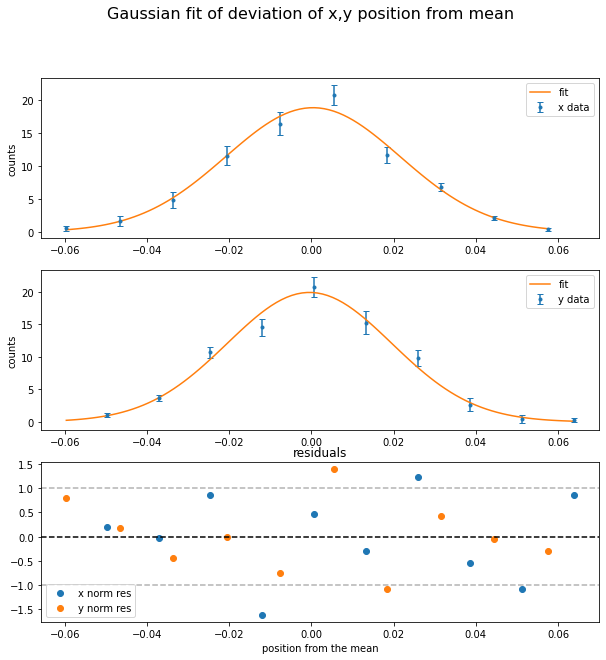

In [39]:
filename = 'data/reproducibility/StrongRep1.txt'
data = extract_data(filename)
analysis = gaussian_analysis(data.x_dec, data.y_dec)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (10,10))

dx = np.linspace(min(analysis.bins_x), max(analysis.bins_x), 100)
ax1.errorbar(analysis.bins_x, analysis.hist_x, fmt = '.', yerr = analysis.sigma_y, capsize = 3, label = 'x data')
ax1.plot(dx, gaussian(dx,*analysis.pOpt_x), label = 'fit')
ax1.set(ylabel = 'counts')
ax1.legend()

dx = np.linspace(min(analysis.bins_x), max(analysis.bins_y), 100)
ax2.errorbar(analysis.bins_y, analysis.hist_y, fmt = '.', yerr= analysis.sigma_x, capsize=3, label = 'y data')
ax2.plot(dx, gaussian(dx,*analysis.pOpt_y), label = 'fit')
ax2.set(ylabel = 'counts')
ax2.legend()

norm_res1 = (analysis.hist_y - gaussian(analysis.bins_y,*analysis.pOpt_y))/analysis.sigma_y
norm_res2 = (analysis.hist_x - gaussian(analysis.bins_x,*analysis.pOpt_x))/analysis.sigma_x

ax3.scatter(analysis.bins_y,norm_res1, label = 'x norm res')
ax3.scatter(analysis.bins_x,norm_res2, label = 'y norm res')
ax3.axhline(y = 0, color = 'k', linestyle = '--')
ax3.axhline(y = 1, color = 'k', linestyle = '--', alpha = 0.3)
ax3.axhline(y = -1, color = 'k', linestyle = '--', alpha = 0.3)
ax3.set(xlabel = 'position from the mean', title = 'residuals')
ax3.legend()

ax3.sharex(ax1)
ax2.sharex(ax1)

fig.suptitle('Gaussian fit of deviation of x,y position from mean', fontsize=16)

fig.savefig('Notes/gaussian_fit_and_residuals.pdf', bbox_inches = 'tight')


<function glob at 0x7f7e0aa5db00>
[[0.02980578 0.02980578]
 [0.053231   0.053231  ]
 [0.06891036 0.06891036]
 [0.0538549  0.0538549 ]
 [0.0530806  0.0530806 ]
 [0.05397241 0.05397241]
 [0.07542172 0.07542172]
 [0.77830255 0.77830255]
 [0.69868757 0.69868757]
 [0.70201436 0.70201436]
 [0.81524558 0.81524558]
 [0.67971888 0.67971888]]

Gaussian Fit Method
0.40871823998998247 +/- 0.029805781623584215 	 0.446388437393322 +/- 0.029805781623584215
0.9999763171682008 +/- 0.05323099967213254 	 1.040592163966109 +/- 0.05323099967213254
1.1089332476506675 +/- 0.0689103569226434 	 1.0692774212921454 +/- 0.0689103569226434
0.6137910851551936 +/- 0.05385489559538782 	 0.6261395638221623 +/- 0.05385489559538782
1.1417770197853854 +/- 0.053080596398451585 	 0.7862739066128699 +/- 0.053080596398451585
1.0966769698221943 +/- 0.05397241279039528 	 0.8466551821154636 +/- 0.05397241279039528
1.4676273439885563 +/- 0.07542171668303364 	 1.0243152266177038 +/- 0.07542171668303364
10.93882844244275 +/- 0.778

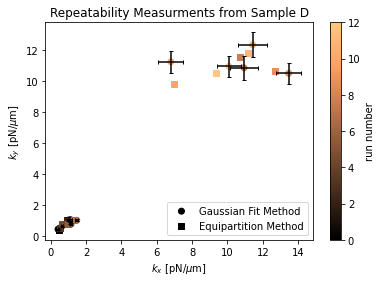

In [46]:
filenames1 = np.sort(glob('data/reproducibility/*[!1-3]_data.txt'))
filenames2 = np.array(glob(('data/reproducibility/Strong*')))
print(glob)
filenames = np.concatenate((filenames1, filenames2))
# print(filenames)

k_arr = []
k_arr_strength_eqi = []
error_arr = []
for filename in filenames:
    ret = extract_data(filename)
    analysis2 = gaussian_analysis(ret.x_dec, ret.y_dec, nbins = 20)
    # print(f"Via Gaussian Fit Method\nk_x = {analysis2.k_x}\nk_y = {analysis2.k_y}")
    k_arr.append([analysis2.k_x, analysis2.k_y])
    # plt.plot(ret.x)
    # plt.plot(ret.y)
    # plt.show()
    std_sigma = np.sqrt(np.diag(analysis2.pCov_x))[1]
    sigma = analysis2.pOpt_x[1]
    kx_error = analysis2.k_x*2*k_b*10**18*T/sigma**3*std_sigma

    std_sigma = np.sqrt(np.diag(analysis2.pCov_y))[1]
    sigma = analysis2.pOpt_y[1]
    ky_error = 2*k_b*10**18*T/sigma**3*std_sigma
    kx_error = 2*k_b*10**18*T/sigma**3*std_sigma
    error_arr.append([kx_error,kx_error])
    
    plt.errorbar(analysis2.k_x, analysis2.k_y, yerr = ky_error, xerr = kx_error, fmt = 'k', capsize=2)

    k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
    k_arr_strength_eqi.append([k_x,k_y])
    

k_arr = np.array(k_arr)
k_arr_strength_eqi = np.array(k_arr_strength_eqi)
error_arr = np.array(error_arr)
#print("Gaussian Method")
#print(f"kx = {np.mean(k_arr[:,0])} p/m {np.std(k_arr[:,0])}")
#print(f"ky = {np.mean(k_arr[:,1])} p/m {np.std(k_arr[:,1])}")

#print("\nEquipartition Method")
#print(f"kx = {np.mean(k_arr_strength_eqi[:,0])} p/m {np.std(k_arr_strength_eqi[:,0])}")
#print(f"ky = {np.mean(k_arr_strength_eqi[:,1])} p/m {np.std(k_arr_strength_eqi[:,1])}")

print(error_arr)

print("\nGaussian Fit Method")
for kx, ky,dkx, dky in np.concatenate((k_arr,error_arr),axis = 1):
    print(kx,"+/-",dkx,"\t",ky,"+/-",dky)

print("\nEquipartition Method")
for kx, ky in k_arr_strength_eqi:
    print(kx,"+/-",np.sqrt(kx),"\t",ky,"+/-",np.sqrt(ky))

plt.scatter(k_arr[:,0], k_arr[:,1], marker = 'o',c = np.linspace(0,len(filenames),len(k_arr[:,0])),cmap = 'copper',  label="Gaussian Fit Method")
plt.scatter(k_arr_strength_eqi[:,0], k_arr_strength_eqi[:,1], marker = 's', c = np.linspace(0,len(filenames),len(k_arr[:,0])), cmap  = 'copper', label = "Equipartition Method")


plt.colorbar(label = 'run number')
plt.xlabel(r"$k_x$ [pN/$\mu$m]")
plt.ylabel(r"$k_y$ [pN/$\mu$m]")
#plt.yscale("Log")
#plt.xscale("Log")
plt.legend()
plt.title("Repeatability Measurments from Sample D") # lol
plt.savefig('Notes/reproducibiliy.pdf')

# Potential Well

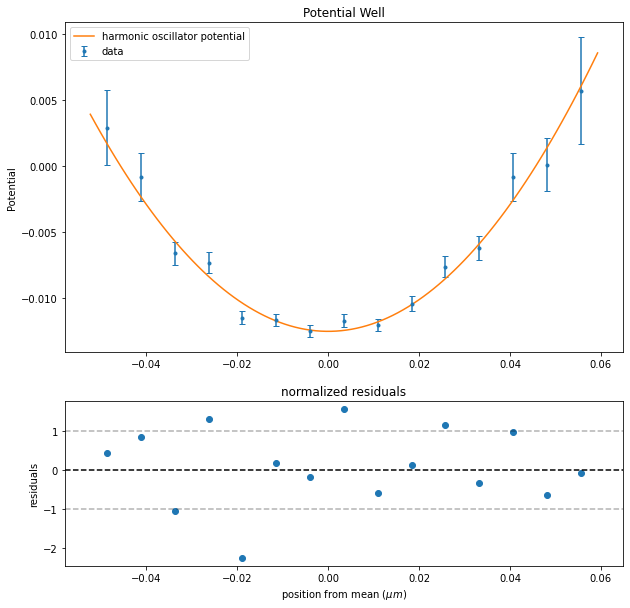

In [43]:
filename = 'data/reproducibility/StrongRep4.txt'
data = extract_data(filename)
analysis = gaussian_analysis(data.x_dec, data.y_dec, nbins = 15)

def potential_well(x,k,b):
    return 1/2*k*x**2 - b

#change into potential
well_dat = -np.log(analysis.hist_x)*T*k_b*10**18
sigma = 1/analysis.hist_x*T*k_b*10**18*analysis.sigma_x


pOpt, pCov = curve_fit(potential_well, analysis.bins_x, well_dat, p0 = [0.1, np.min(well_dat)], sigma = sigma, absolute_sigma=True)

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,10), gridspec_kw = {'height_ratios': (2,1)})
dx = np.linspace(min(data.x_dec),max(data.x_dec),100)
dy = potential_well(dx, *pOpt)
ax1.errorbar(analysis.bins_x, well_dat, fmt = '.', yerr = sigma, capsize=3, label = 'data')
ax1.plot(dx, dy, label = 'harmonic oscillator potential')
ax1.set(title = 'Potential Well', ylabel='Potential')
ax1.legend()
ax1.sharex(ax2)


norm_res = (well_dat - potential_well(analysis.bins_x, *pOpt))/sigma
ax2.plot(analysis.bins_x, norm_res, 'o')
ax2.axhline(y = 0, color = 'k', linestyle = '--')
ax2.axhline(y = 1, color = 'k', linestyle = '--', alpha = 0.3)
ax2.axhline(y = -1, color = 'k', linestyle = '--', alpha = 0.3)
ax2.set(title = 'normalized residuals', ylabel = 'residuals', xlabel = 'position from mean ($\mu m$)')
fig.savefig('Notes/potential_well_fit.pdf')

# Data Extraction

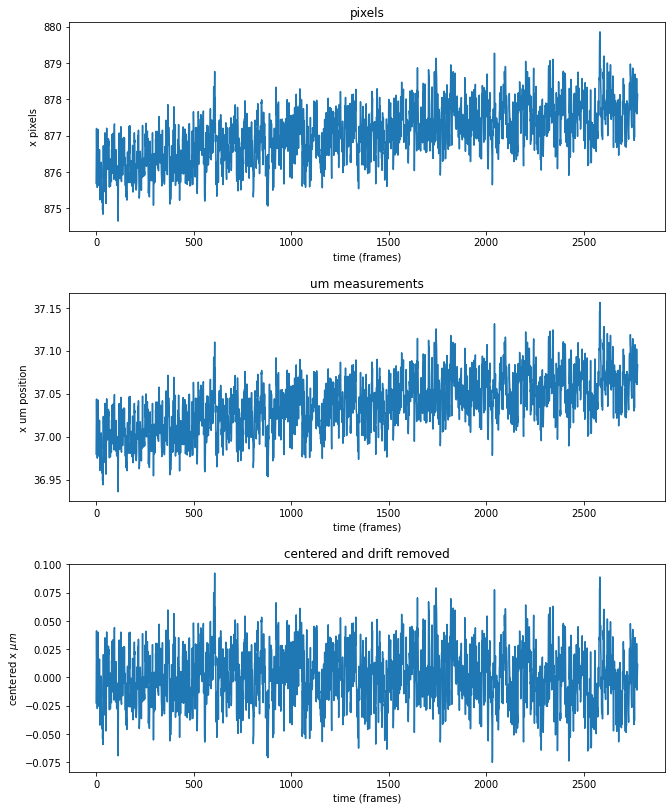

In [16]:
filename = 'data/reproducibility/StrongRep5.txt'

data = extract_data(filename)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (9,11))
fig.tight_layout()

ax1.plot(data.raw_x, label = 'raw')
ax2.plot(data.x_dat, label = 'dat')
ax3.plot(data.x, label = 'clean')

ax1.set(title = 'pixels', xlabel = 'time (frames)', ylabel= 'x pixels')
ax2.set(title = 'um measurements', xlabel = 'time (frames)', ylabel = 'x um position')
ax3.set(title = 'centered and drift removed', xlabel = 'time (frames)', ylabel = 'centered x $\mu m$')
plt.subplots_adjust(hspace = 0.3)
fig.savefig('Notes/data_cleaning_process.pdf', bbox_inches = 'tight')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4bb45f9e-f9d7-4771-843d-2a6451217511' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>